# 連続修正

In [1]:
from shiori.utils.viewer import set_plot_params, sns, plt
from shiori.utils.path import ProjectPath
from pathlib import Path
import numpy as np
set_plot_params()
name = Path().cwd().name + "/continuity_crrection"
proj = ProjectPath(save_dst=name)
save_dir = proj.save_dir
save_dir.mkdir(parents=True, exist_ok=True)
plt.rcParams.update({
    "text.usetex": True,               # LaTeXを使う
    "font.family": "Arial",            # セリフ体
    "font.serif": ["Computer Modern"], # LaTeX標準フォント
})


In [2]:
from math import comb, sqrt
from math import erf

# ==== 基本関数 ====
def normal_cdf(z):  # Φ(z)
    return 0.5 * (1 + erf(z / np.sqrt(2)))

def binom_pmf(n, p):
    k = np.arange(n + 1)
    pmf = np.array([comb(n, ki) * (p**ki) * ((1 - p) ** (n - ki)) for ki in k], dtype=float)
    return k, pmf

def exact_tail(n, p0, x, side="right"):
    k, pmf = binom_pmf(n, p0)
    if side == "right":
        return pmf[k >= x].sum()
    if side == "left":
        return pmf[k <= x].sum()
    # two-sided: small-probability two-tail (最小の両側確率)
    p_obs = pmf[x]
    return pmf[pmf <= p_obs].sum()

def normal_tail(n, p0, x, side="right", cc=True):
    mu = n * p0
    sigma = sqrt(n * p0 * (1 - p0))
    if side == "right":
        z = (x - (mu + (0.5 if cc else 0.0))) / sigma
        return 1 - normal_cdf(z)
    if side == "left":
        z = (x - (mu - (0.5 if cc else 0.0))) / sigma
        return normal_cdf(z)
    # two-sided
    # 上側は -0.5, 下側は +0.5 を使う
    z_up = (x - (mu + (0.5 if cc else 0.0))) / sigma
    z_lo = (x - (mu - (0.5 if cc else 0.0))) / sigma
    # 観測がどちら側かで片側pを選び2倍
    if x >= mu:
        p_one = 1 - normal_cdf(z_up)
    else:
        p_one = normal_cdf(z_lo)
    return 2 * p_one

n=40
p0=0.5
x=26
side="right"
cc=True

k, pmf = binom_pmf(n, p0)
mu = n * p0
sigma = sqrt(n * p0 * (1 - p0))
mu, sigma

(20.0, 3.1622776601683795)

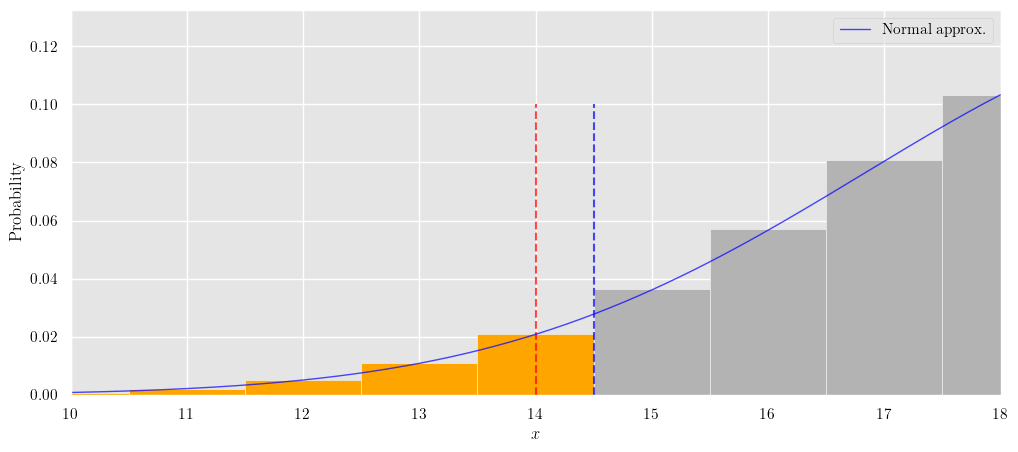

In [3]:
n=40
p0=0.5
x=14
side="left"
cc=True

k, pmf = binom_pmf(n, p0)
mu = n * p0
sigma = sqrt(n * p0 * (1 - p0))
mu, sigma
p_exact = exact_tail(n, p0, x, side)
p_norm_cc = normal_tail(n, p0, x, side, cc=True)
p_norm_nocc = normal_tail(n, p0, x, side, cc=False)

# 図
plt.figure(figsize=(12, 5))
ax = plt.gca()
# bar
bars = ax.bar(k, pmf, width=1, align="center")

# x以上を着色
for kk, rect in zip(k, bars):
    if kk <= x:
        rect.set_facecolor("orange")  # tail
    else:
        rect.set_facecolor("0.7")     # body (グレー)


ax.vlines(x=x, ymin=0, ymax=0.1, color="red", linestyle="dashed", alpha=0.7)
ax.vlines(x=x+0.5, ymin=0, ymax=0.1, color="blue", linestyle="dashed", alpha=0.7)

xs = np.linspace(-0.5, n + 0.5, 2000)
pdf = (1 / (sigma * np.sqrt(2 * np.pi))) * np.exp(-0.5 * ((xs - mu) / sigma) ** 2)
ax.plot(xs, pdf, color="blue", alpha=0.7, label="Normal approx.", linewidth=1)

ax.set_xlabel("$x$")
ax.set_ylabel("Probability")
ax.set_xlim(10, 18)

plt.legend()

plt.show()

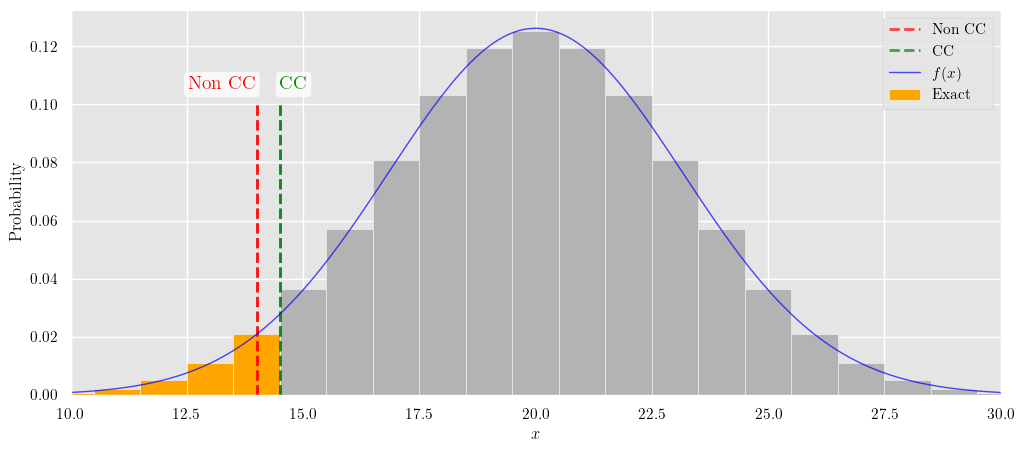

In [ ]:
# 図
plt.figure(figsize=(12, 5))
ax = plt.gca()

# bar: Exact
bars = ax.bar(k, pmf, width=1, align="center", label="Exact")

# tail 着色
for kk, rect in zip(k, bars):
    rect.set_facecolor("orange" if kk <= x else "0.7")

# しきい値線: Non CC, CC
ax.vlines(
    x=x, ymin=0, ymax=0.1, color="red", linestyle="dashed",
    alpha=0.7, label="Non CC", linewidth=2)
ax.vlines(
    x=x+0.5, ymin=0, ymax=0.1, color="green", linestyle="dashed",
    alpha=0.7, label="CC", linewidth=2)

# しきい値線
yline = 0.1
ax.vlines(x=x,     ymin=0, ymax=yline, color="red",   linestyle="dashed", alpha=0.7, linewidth=2)
ax.vlines(x=x+0.5, ymin=0, ymax=yline, color="green", linestyle="dashed", alpha=0.7, linewidth=2)

# 線の上にラベル（上方向に少しオフセット）
ax.annotate("Non CC", xy=(x, yline),     xytext=(-25, 8), textcoords="offset points",
            ha="center", va="bottom", color="red", fontsize=14,
            bbox=dict(boxstyle="round,pad=0.2", fc="white", ec="none", alpha=0.8))

ax.annotate("CC",     xy=(x+0.5, yline), xytext=(10, 8), textcoords="offset points",
            ha="center", va="bottom", color="green", fontsize=14,
            bbox=dict(boxstyle="round,pad=0.2", fc="white", ec="none", alpha=0.8))

# 正規近似カーブ
xs = np.linspace(-0.5, n + 0.5, 2000)
pdf = (1 / (sigma * np.sqrt(2 * np.pi))) * np.exp(-0.5 * ((xs - mu) / sigma) ** 2)
ax.plot(xs, pdf, color="blue", alpha=0.7, label="$f(x)$", linewidth=1)
# 凡例を大きく
ax.legend(loc="upper right", fontsize=50, title="Legend", title_fontsize=16,
          frameon=True, handlelength=2.5)
ax.set_xlabel("$x$")
ax.set_ylabel("Probability")
ax.set_xlim(10, 30)
ax.legend()
plt.savefig(save_dir / "continuity_correction.png", dpi=300, bbox_inches="tight", facecolor="white")
plt.show()

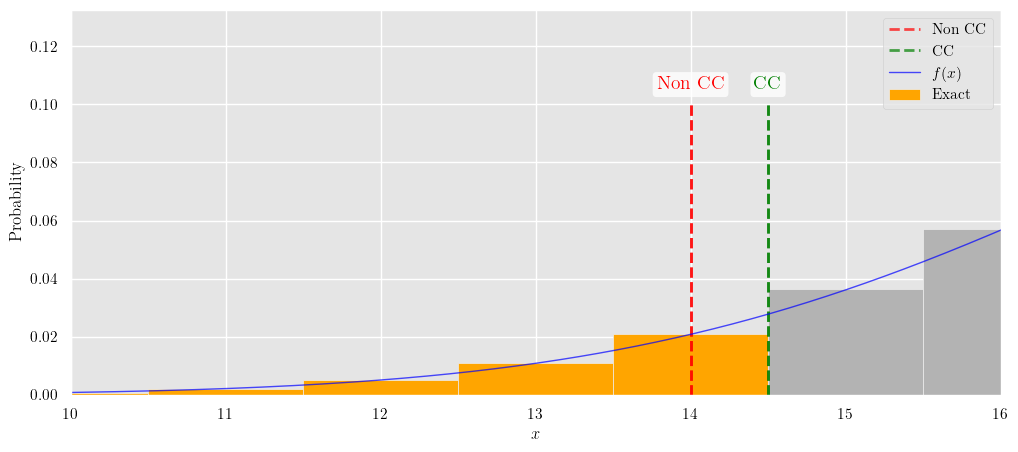

In [38]:
# 図
plt.figure(figsize=(12, 5))
ax = plt.gca()

# bar: Exact
bars = ax.bar(k, pmf, width=1, align="center", label="Exact")

# tail 着色
for kk, rect in zip(k, bars):
    rect.set_facecolor("orange" if kk <= x else "0.7")

# しきい値線: Non CC, CC
ax.vlines(
    x=x, ymin=0, ymax=0.1, color="red", linestyle="dashed",
    alpha=0.7, label="Non CC", linewidth=2)
ax.vlines(
    x=x+0.5, ymin=0, ymax=0.1, color="green", linestyle="dashed",
    alpha=0.7, label="CC", linewidth=2)

# しきい値線
yline = 0.1
ax.vlines(x=x,     ymin=0, ymax=yline, color="red",   linestyle="dashed", alpha=0.7, linewidth=2)
ax.vlines(x=x+0.5, ymin=0, ymax=yline, color="green", linestyle="dashed", alpha=0.7, linewidth=2)

# 線の上にラベル（上方向に少しオフセット）
ax.annotate("Non CC", xy=(x, yline),     xytext=(0, 8), textcoords="offset points",
            ha="center", va="bottom", color="red", fontsize=14,
            bbox=dict(boxstyle="round,pad=0.2", fc="white", ec="none", alpha=0.8))

ax.annotate("CC",     xy=(x+0.5, yline), xytext=(0, 8), textcoords="offset points",
            ha="center", va="bottom", color="green", fontsize=14,
            bbox=dict(boxstyle="round,pad=0.2", fc="white", ec="none", alpha=0.8))

# 正規近似カーブ
xs = np.linspace(-0.5, n + 0.5, 2000)
pdf = (1 / (sigma * np.sqrt(2 * np.pi))) * np.exp(-0.5 * ((xs - mu) / sigma) ** 2)
ax.plot(xs, pdf, color="blue", alpha=0.7, label="$f(x)$", linewidth=1)
# 凡例を大きく
ax.legend(loc="upper right", fontsize=50, title="Legend", title_fontsize=16,
          frameon=True, handlelength=2.5)
ax.set_xlabel("$x$")
ax.set_ylabel("Probability")
ax.set_xlim(10, 16)
ax.legend()
plt.savefig(save_dir / "continuity_correction_zoom.png", dpi=300, bbox_inches="tight", facecolor="white")
plt.show()

In [78]:
# ===== 設定 =====
p0   = 0.5          # 真の確率
side = "left"       # "left" or "right"
a    = 0.35         # 閾値比 c = floor(a*n)
n_min, n_max, n_step = 2, 100, 4

# ===== 補助関数 =====
try:
    from scipy.stats import binom, norm
    use_scipy = True
except Exception:
    use_scipy = False
    from math import erf

def _phi(z):  # 標準正規CDF（scipy無いとき）
    return 0.5*(1 + erf(z/np.sqrt(2)))

def exact_tail(n, p, c, side):
    if use_scipy:
        return binom.cdf(c, n, p) if side=="left" else binom.sf(c-1, n, p)
    # SciPyなし
    from math import comb
    if side == "left":
        return sum(comb(n,k)*(p**k)*((1-p)**(n-k)) for k in range(0, c+1))
    else:
        return sum(comb(n,k)*(p**k)*((1-p)**(n-k)) for k in range(c, n+1))

def normal_tail(n, p, c, side, cc=False):
    mu = n*p
    sigma = sqrt(n*p*(1-p))
    if side == "left":
        t = (c + (0.5 if cc else 0.0) - mu)/sigma
        return norm.cdf(t) if use_scipy else _phi(t)
    else:
        t = (c - (0.5 if cc else 0.0) - mu)/sigma
        val = norm.cdf(t) if use_scipy else _phi(t)
        return 1.0 - val

# ===== データ計算 =====
ns = np.arange(n_min, n_max+1, n_step)
y_exact = np.empty_like(ns, float)
y_noncc = np.empty_like(ns, float)
y_cc    = np.empty_like(ns, float)
cs      = np.empty_like(ns, int)

for i, n in enumerate(ns):
    c = floor(a*n)
    cs[i] = c
    y_exact[i] = exact_tail(n, p0, c, side)
    y_noncc[i] = normal_tail(n, p0, c, side, cc=False)
    y_cc[i]    = normal_tail(n, p0, c, side, cc=True)

d_noncc = y_noncc - y_exact
d_cc    = y_cc    - y_exact

# ===== アニメーション: 差分（Approx - Exact） =====
fig, ax = plt.subplots(figsize=(7, 4.5))
ax.axhline(0, color="0.5", lw=1, linestyle="--")
line_noncc, = ax.plot([], [], lw=1, marker="o", label="Non CC - Exact", color="red")
line_cc,    = ax.plot([], [], lw=1, marker="o", label="CC - Exact", color="green")

ax.set_xlabel("$n$")
ax.set_ylabel("Difference (CC or Non CC - Exact)")
ax.set_xlim(ns.min(), ns.max())
ax.set_ylim(-0.01, 0.1)

y_all = np.r_[d_noncc, d_cc]
pad = max(1e-4, 0.05*np.ptp(y_all) if np.ptp(y_all)>0 else 0.01)
ax.set_ylim(-0.2, 0.1)
ax.legend(fontsize=12, loc="upper right")
txt = ax.text(0.02, 0.97, "", transform=ax.transAxes, ha="left", va="top", fontsize=12)

def init():
    line_noncc.set_data([], [])
    line_cc.set_data([], [])
    txt.set_text("")
    return line_noncc, line_cc, txt

def update(frame):
    i = frame + 1
    x = ns[:i]
    line_noncc.set_data(x, d_noncc[:i])
    line_cc.set_data(x, d_cc[:i])
    n_cur, c_cur = ns[i-1], cs[i-1]
    txt.set_text(
        f"n={n_cur}, c={c_cur}"
    )
    return line_noncc, line_cc, txt

ani = animation.FuncAnimation(
    fig, update, frames=len(ns), init_func=init,
    blit=True, interval=120, repeat=True
)

# GIF保存（Pillowが必要）
ani.save(save_dir / "cc_diff_convergence.gif", writer="pillow", fps=5, dpi=300)
plt.close(fig)
print("saved: cc_diff_convergence.gif")


saved: cc_diff_convergence.gif


In [87]:
from matplotlib import animation
from math import floor, sqrt
try:
    from scipy.stats import binom, norm
    use_scipy = True
except Exception:
    use_scipy = False
    from math import erf

# ===== 設定 =====
n      = 50
side   = "left"       # "left" or "right"
a      = 0.05         # c = floor(a*n)
c      = floor(a*n)
eps    = 1e-6
p_grid = np.linspace(eps, 1-eps, 401)  # 0~1

# ===== 補助 =====
def _phi(z):
    return 0.5*(1 + erf(z/np.sqrt(2)))

def exact_tail(n, p, c, side):
    if use_scipy:
        return binom.cdf(c, n, p) if side=="left" else binom.sf(c-1, n, p)
    from math import comb
    if side == "left":
        return sum(comb(n,k)*p**k*(1-p)**(n-k) for k in range(0, c+1))
    else:
        return sum(comb(n,k)*p**k*(1-p)**(n-k) for k in range(c, n+1))

def normal_tail(n, p, c, side, cc=False):
    mu = n*p
    sigma = sqrt(n*p*(1-p))
    if side == "left":
        t = (c + (0.5 if cc else 0.0) - mu)/sigma
        return norm.cdf(t) if use_scipy else _phi(t)
    else:
        t = (c - (0.5 if cc else 0.0) - mu)/sigma
        val = norm.cdf(t) if use_scipy else _phi(t)
        return 1.0 - val

# ===== 事前計算 =====
y_exact = np.array([exact_tail(n, p, c, side) for p in p_grid])
y_noncc = np.array([normal_tail(n, p, c, side, cc=False) for p in p_grid])
y_cc    = np.array([normal_tail(n, p, c, side, cc=True)  for p in p_grid])
d_noncc = y_noncc - y_exact
d_cc    = y_cc    - y_exact

# ===== アニメーション =====
fig, ax = plt.subplots(figsize=(7, 4.5))
ax.axhline(0, color="0.5", lw=1, ls="--")
line_noncc, = ax.plot([], [], lw=1.8, marker="o", ms=3, markevery=20, color="red",   label="Non CC - Exact")
line_cc,    = ax.plot([], [], lw=1.8, marker="o", ms=3, markevery=20, color="green", label="CC - Exact")

ax.set_xlabel(r"$p$")
ax.set_ylabel("Difference (CC or Non CC − exact)")
ax.set_xlim(0, 1)
y_all = np.r_[d_noncc, d_cc]
pad = max(1e-3, 0.05*np.ptp(y_all))
ax.set_ylim(y_all.min()-pad, y_all.max()+pad)
ax.legend(loc="best")
title = ax.set_title(f"n={n}, c={c}")
txt = ax.text(0.02, 0.97, "", transform=ax.transAxes, ha="left", va="top", fontsize=11)

def init():
    line_noncc.set_data([], [])
    line_cc.set_data([], [])
    txt.set_text("")
    return line_noncc, line_cc, txt

def update(frame):
    i = frame + 2  # 少しずつ伸ばす（最小2点）
    x = p_grid[:i]
    line_noncc.set_data(x, d_noncc[:i])
    line_cc.set_data(x, d_cc[:i])
    # txt.set_text(f"p ∈ [0, {p_grid[i-1]:.3f}]")
    return line_noncc, line_cc, txt

ani = animation.FuncAnimation(
    fig, update, frames=len(p_grid)-1, init_func=init,
    blit=True, interval=60, repeat=True
)

out_path = (save_dir / "cc_diff_over_p.gif") if "save_dir" in globals() else "cc_diff_over_p.gif"
ani.save(out_path, writer="pillow", fps=24, dpi=200)
plt.close(fig)
print(f"saved: {out_path}")


saved: /home/katsuji/project/shioru/src/.vuepress/public/assets/images/test/continuity_crrection/cc_diff_over_p.gif


In [69]:
# ===== パラメータ =====
p0    = 0.5          # 二項の p
side  = "left"       # left 固定
a     = 0.35         # しきい値比率: x = floor(a*n)
n_min, n_max, n_step = 10, 200, 2
yline = 0.1          # vline の高さ

# ===== ユーティリティ =====
def binom_pmf(n, p):
    k = np.arange(n+1)
    pmf = np.array([comb(n, i) * p**i * (1-p)**(n-i) for i in k], dtype=float)
    return k, pmf

def normal_pdf(xs, mu, sigma):
    return (1.0/(sigma*np.sqrt(2*np.pi))) * np.exp(-0.5*((xs-mu)/sigma)**2)

# ===== アニメーション描画 =====
fig, ax = plt.subplots(figsize=(12, 5))

def draw_frame(n):
    ax.clear()

    # しきい値と分布
    x = floor(a*n)
    k, pmf = binom_pmf(n, p0)
    mu = n*p0
    sigma = sqrt(n*p0*(1-p0))

    # bar: Exact
    bars = ax.bar(k, pmf, width=1, align="center", label="Exact")
    for kk, rect in zip(k, bars):
        rect.set_facecolor("orange" if kk <= x else "0.7")

    # しきい値線とラベル
    ax.vlines(x=x,     ymin=0, ymax=yline, color="red",   linestyle="dashed", alpha=0.7, linewidth=2, label="Non CC")
    ax.vlines(x=x+0.5, ymin=0, ymax=yline, color="green", linestyle="dashed", alpha=0.7, linewidth=2, label="CC")
    ax.annotate("Non CC", xy=(x, yline),     xytext=(0, 8), textcoords="offset points",
                ha="center", va="bottom", color="red", fontsize=14,
                bbox=dict(boxstyle="round,pad=0.2", fc="white", ec="none", alpha=0.8))
    ax.annotate("CC",     xy=(x+0.5, yline), xytext=(0, 8), textcoords="offset points",
                ha="center", va="bottom", color="green", fontsize=14,
                bbox=dict(boxstyle="round,pad=0.2", fc="white", ec="none", alpha=0.8))

    # 正規近似カーブ
    xs = np.linspace(-0.5, n+0.5, 2000)
    pdf = normal_pdf(xs, mu, sigma)
    ax.plot(xs, pdf, color="blue", alpha=0.7, label="$f(x)$", linewidth=1)

    # 体裁
    ax.set_xlabel("$x$")
    ax.set_ylabel("Probability")

    # ズーム: 左片側の様子が見えるように動的ウィンドウ
    half = max(6, int(2.5*sigma))  # 適度な幅
    x_min = max(0, x - half)
    x_max = min(n, x + half)
    ax.set_xlim(x_min, x_max)

    ax.set_ylim(0, max(pmf.max(), pdf.max())*1.1)
    ax.legend(loc="upper right", fontsize=12, frameon=True)
    ax.set_title(f"n={n}, p={p0}, side='left', x=floor({a}*n)={x}")

def init():
    draw_frame(n_min)
    return []

def update(frame):
    n = n_min + frame*n_step
    draw_frame(n)
    return []

frames = (n_max - n_min)//n_step + 1
ani = animation.FuncAnimation(fig, update, frames=frames, init_func=init,
                              blit=False, interval=140, repeat=True)

ani.save("continuity_correction_zoom_anim.gif", writer="pillow", fps=10)
plt.close(fig)
print("saved: continuity_correction_zoom_anim.gif")


saved: continuity_correction_zoom_anim.gif


In [75]:
from math import comb, floor, sqrt, pi, exp
from math import comb, floor, sqrt, pi

# ===== 設定 =====
p0    = 0.5
a     = 0.35                 # c = floor(a*n)
n_min, n_max, n_step = 10, 300, 2
yline = 0.38                 # 標準正規の最大 ~0.3989 に合わせる

def binom_pmf(n, p):
    k = np.arange(n+1)
    pmf = np.array([comb(n, i) * p**i * (1-p)**(n-i) for i in k], dtype=float)
    return k, pmf

def phi(z):
    return (1.0/np.sqrt(2*pi))*np.exp(-0.5*z*z)

fig, ax = plt.subplots(figsize=(12, 5))

def draw_frame(n):
    ax.cla()  # ← まるごとクリアして毎回描き直す

    c = floor(a*n)
    k, pmf = binom_pmf(n, p0)
    mu, sigma = n*p0, sqrt(n*p0*(1-p0))

    # 標準化座標へ
    z_k = (k - mu) / sigma
    heights = sigma * pmf           # sigma * P(X=k) ≈ φ(z) * (1)
    widths  = np.full_like(heights, 1.0/sigma, dtype=float)

    # 標準正規は毎回描く（固定スケール）
    z_grid = np.linspace(-4, 4, 1000)
    ax.plot(z_grid, phi(z_grid), color="blue", lw=1.5, label=r"$\varphi(z)$")

    # bar（標準化空間）
    bars = ax.bar(z_k, heights, width=widths, align="center", alpha=0.85, edgecolor="none", label="Exact")
    z_noncc = (c - mu)/sigma
    z_cc    = (c + 0.5 - mu)/sigma
    for zk, rect in zip(z_k, bars):
        rect.set_facecolor("orange" if zk <= z_noncc else "0.7")

    # しきい値線とラベル
    ax.vlines(z_noncc, 0, yline, color="red",   linestyle="dashed", alpha=0.85, lw=2, label="Non CC")
    ax.vlines(z_cc,    0, yline, color="green", linestyle="dashed", alpha=0.85, lw=2, label="CC")
    ax.annotate("Non CC", (z_noncc, yline), xytext=(-25, 8), textcoords="offset points",
                ha="center", va="bottom", color="red", fontsize=12,
                bbox=dict(boxstyle="round,pad=0.2", fc="white", ec="none", alpha=0.85))
    ax.annotate("CC",     (z_cc,    yline), xytext=(10, 8),  textcoords="offset points",
                ha="center", va="bottom", color="green", fontsize=12,
                bbox=dict(boxstyle="round,pad=0.2", fc="white", ec="none", alpha=0.85))

    # 体裁（固定）
    ax.set_xlim(-4, 4)
    ax.set_ylim(0, 0.42)
    ax.set_xlabel(r"$z=(x-\mu)/\sigma$")
    ax.set_ylabel("density / scaled mass")
    ax.set_title(f"Standardized view: n={n}, p={p0}, c=floor({a}*n)={c}")
    ax.legend(loc="upper right", fontsize=12, frameon=True)

def init():
    draw_frame(n_min)
    return []

def update(frame):
    n = n_min + frame*n_step
    draw_frame(n)
    return []

frames = (n_max - n_min)//n_step + 1
ani = animation.FuncAnimation(fig, update, frames=frames, init_func=init,
                              blit=False, interval=140, repeat=True)

ani.save("standardized_bins_converge.gif", writer="pillow", fps=10)
plt.close(fig)
print("saved: standardized_bins_converge.gif")


saved: standardized_bins_converge.gif
